# Aprendendo sobre a dimensão das coisas

## O experimento de Eratóstenes

```{admonition} Eratóstenes de Sirenea
:class: bio

<table>
  <tr>
    <td style="width: 160px;">
      <img src="../00_images/people/eratosthenes.jpg" width="150">
    </td>
    <td>
      <strong>Eratóstenes de Cirene (Cirene, 276 a.C. — Alexandria, 194 a.C.)</strong><br>
      Eratóstenes foi um polímata grego que, embora mais conhecido por medir com notável precisão o raio da Terra, também fez importantes contribuições à astronomia. Dirigiu a Biblioteca de Alexandria e compilou um catálogo de estrelas e constelações. Sua medição do tamanho da Terra, feita com base na sombra de obeliscos em duas cidades diferentes no solstício, foi fundamental para a compreensão da escala do mundo.
    </td>
  </tr>
</table>

```

### Nosso objetivo

:::{figure} ../00_images/cap_01/eratosthenes.jpg
:width: 70 %
:alt: map to buried treasure

Uma ideia sensacional. Créditos da figura [^1]
[^1]: https://images.fineartamerica.com/images-medium-large-5/eratosthenes-experiment-science-photo-library.jpg
:::

Vamos reproduzir a experiência de Eratóstenes com a ajuda do computador, assim não vamos precisar contar os nossos passos em uma viagem de mais de 800 km. Embora a experiência pareça bem simples, existe uma riqueza de sutilezas que devem ser consideradas, e muito o que aprender.

:::{note}
:class: 
:name: roteiro-eratostenes

1. Vamos obter as coordenadas geográficas das cidades de Alexandria e Aswan.
   1. Vamos usar a biblioteca `osmnx` para obter os objetos `geocode` como coordenadas **Lat** e **Lon**. 
2. Utilizando `geopy` podemos obter a distância geodésica entre as duas cidades de maneira bastante direta.
3. Vamos escolher o ano $200 ac$ para nosso experimento, uma época em que o idealizador estava vivo.
4. Precisamos determinar o dia do solstício de verão.
   1. Vamos utilizar a biblioteca `skyfield` para realizar os cálculos astronômicos.
   2. Precisamos de informações sobre as posições do Sol e da Terra neste ano.
      1. O serviço de efemérides [JPL/NASA](https://naif.jpl.nasa.gov/naif/)  pode fornecer os dados que queremos.
5. Precisamos determinar o meio-dia local nas duas cidades.
   1. Já temos como calcular a posição do Sol, vamos determinar as passagens do Sol pelo meridiano local.
6. A partir do meio-dia em Aswan, vamos contruir um vetor de tempos com duração de duas horas e examinar o tamanho da sombra projetada pelo Sol nas duas cidades.
   1. $$ \mathcal{L} = \frac{h}{\mathrm{Alt_\odot}} $$
7. Vamos fazer uma visualização em 3D para ver como seria a sombra no chão.
8. Vamos fazer um gráfico com o tamanho das sombras.
9. Vamos obter uma estimativa do radio da Terra fazendo a mesma suposição de eratóstenes.
10. Vamos agora fazer um raciocínio inverso e usar nossos dados para obter a latitude e longitude e a partir destas informações calcular o Raio da Terra levando em conta as posições reais das cidades, que poderiam ser medidas na época antiga se houvessem relógios confiáveis.
:::

In [ ]:
import pyvista as pv
from src.astroufcg.grecia.eratostenes import (
    set_experiment,
    view_shadow_length,
    view_shadow_3D,
    setup
)
path = "../../astroUFCG/"
setup(path)
pv.set_jupyter_backend('trame')

alexandria = "alexandria, egypt"
aswan = "aswan, egypt"
df = set_experiment(alexandria, aswan, year=-200, object_height=10)

### Visualização da Sombra em 3D

In [ ]:
p = pv.Plotter(notebook=True, lighting=None)
p.renderer.shadow_map_resolution = 2048  #
p = view_shadow_3D("alexandria", df, prefix="01", p=p)
p.show()

Widget(value='<iframe src="http://localhost:41257/index.html?ui=P_0x7541be1b47d0_0&reconnect=auto" class="pyvi…

### O comprimento da sombra como função do tempo

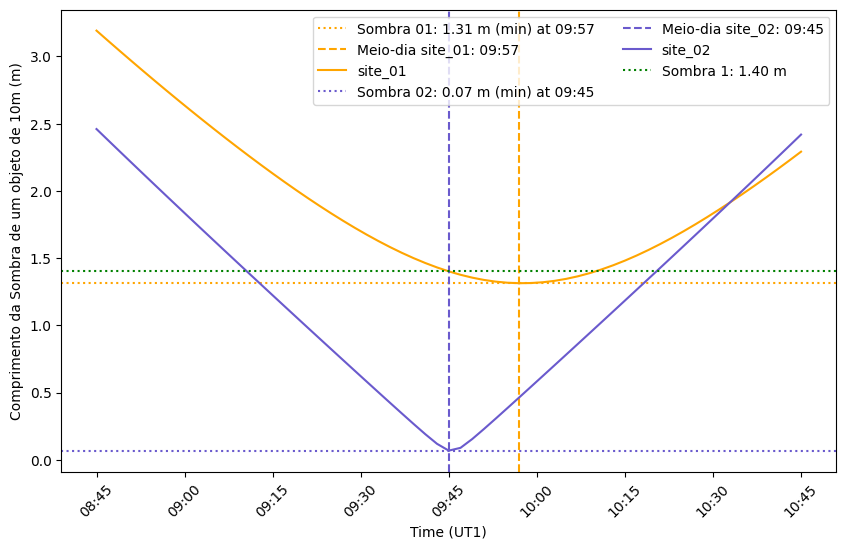

In [ ]:
view_shadow_length(df)

In [ ]:
from geopy.distance import geodesic, great_circle
import osmnx as ox
import numpy as np
from rich.console import Console
from rich.table import Table
h = 10
alexandria_coords = ox.geocode(alexandria)
aswan_coords = ox.geocode(aswan)
distance = geodesic(alexandria_coords, aswan_coords).km
great_circle_distance = great_circle(alexandria_coords, aswan_coords).km

noon_aswan = df["time_02"].iloc[df.reset_index()["shadow_length_02"].idxmin()]
noon_alexandria = df["time_02"].iloc[df.reset_index()["shadow_length_01"].idxmin()]

shadow_length_01 = df[df.time_02==noon_aswan]["shadow_length_01"].values[0]
shadow_length_02 = df[df.time_02==noon_aswan]["shadow_length_02"].values[0]
min_shadow_01 = df[df.time_02==noon_alexandria]["shadow_length_01"].values[0]

sol_coords_01 = df[df.time_02==noon_aswan][["alt_01", "az_01"]].values[0]
sol_coords_02 = df[df.time_02==noon_aswan][["alt_02", "az_02"]].values[0]
sol_coords_a = df[df.time_02==noon_alexandria][["alt_01", "az_01"]].values[0]

theta_alexandria = np.arctan(shadow_length_01 / h)  # Assuming object height is 10
theta_aswan = np.arctan(shadow_length_02 / h)  # Assuming object height is 10

R_terra = distance / theta_alexandria


### Reproduzindo o Experimento de Eratosthenes

In [ ]:
table = Table(title="Experimento de Erathostenes")

table.add_column("Grandezas", justify="right", style="cyan", no_wrap=True)
table.add_column("Alexandria", style="yellow")
table.add_column("Aswann", justify="right", style="green")

table.add_row("meio-dia", noon_alexandria.strftime("%H:%M"), noon_aswan.strftime("%H:%M"))
table.add_row("coordenadas", str(alexandria_coords), str(aswan_coords))
table.add_row("sombra", f"{shadow_length_01:.2f} m", f"{shadow_length_02:.2f} m")
table.add_row("ângulo", f"{np.degrees(theta_alexandria):.2f}°", f"{np.degrees(theta_aswan):.2f}°")
table.add_row("Sol meio-dia", f"alt: {sol_coords_a[0]:.2f}°, az: {sol_coords_a[1]:.2f}°", f"alt: {sol_coords_02[0]:.2f}°, az: {sol_coords_02[1]:.2f}°")
table.add_row("Sol meio-dia aswan", f"alt: {sol_coords_01[0]:.2f}°, az: {sol_coords_01[1]:.2f}°", f"alt: {sol_coords_02[0]:.2f}°, az: {sol_coords_02[1]:.2f}°")
d_theta = np.degrees(theta_aswan - theta_alexandria)
d_phi = np.abs((noon_alexandria - noon_aswan).total_seconds()) * 24 / 3600  # Convertendo de segundos para horas
console = Console()
console.print(table)


                        Experimento de Erathostenes                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Grandezas ┃ Alexandria               ┃                   Aswann ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           meio-dia │ 09:57                    │                    09:45 │
│        coordenadas │ (31.1991806, 29.8951716) │   (24.091071, 32.897306) │
│             sombra │ 1.40 m                   │                   0.07 m │
│             ângulo │ 7.98°                    │                    0.39° │
│       Sol meio-dia │ alt: 82.52°, az: 179.12° │ alt: 89.61°, az: 163.38° │
│ Sol meio-dia aswan │ alt: 82.02°, az: 158.93° │ alt: 89.61°, az: 163.38° │
└────────────────────┴──────────────────────────┴──────────────────────────┘

### Aprendendo sobre Latitudes e Longitudes

A diferença de Latitude é a diferença de altura do Sol nos dois locais, medidos na mesma hora.

In [ ]:
# O sinal é porque a altitude do sol é 90 menos o angulo da sombra
delta_lat = float(-(sol_coords_a - sol_coords_02)[0])
console.print(f"Delta latitude: {delta_lat:.2f}°")

Delta latitude: 7.09°

A diferença de longitude é a diferença de tempo para as passagens no meridiano, convertida em horas.
Falta apenas calcular o tempo em Alexandria.

In [ ]:
# O sinal esta relacionado com a rotação da terra
delta_t = (noon_alexandria - noon_aswan).total_seconds()
# Convertendo em graus
delta_lon = float(-delta_t * 360 / (24 * 3600))  # 24 hours in seconds
console.print(f"Delta longitude: {delta_lon:.2f}°")

Delta longitude: -3.00°

Comparando com os dados geográficos temos: 

In [ ]:
def format_list(lst):
    return ", ".join(f"{x:.2f}" for x in lst)

delta_coords_astro = [delta_lat, delta_lon]
delta_coords_geo = [alexandria_coords[0] - aswan_coords[0], alexandria_coords[1] - aswan_coords[1]]
console.print(f"Delta coordenadas astronômicas: {format_list(delta_coords_astro)}")
console.print(f"Delta coordenadas geográficas: {format_list(delta_coords_geo)}")

Delta coordenadas astronômicas: 7.09, -3.00

Delta coordenadas geográficas: 7.11, -3.00

## Correções ao Experimento

Precisamos considerar que: 
- ‼️O tamanho da sombra em Aswan não é zero, sua latitude não é no trópico de câncer.
- ‼️A longitude das cidades não é a mesma.

Para dois pontos na esfera, a distância entre eles é dada pela fórmula de Haversine

$$ D(x, y) = 2 \mathrm{arcsen}\left[ \sqrt{\sin^2\left(\frac{x_{lat} - y_{lat}}{2}\right) + \cos(x_{lat})\cos({y_{lat}}) \sin^2\left(\frac{x_{lon} - y_{lon}}{2}\right)} \right]
$$

A diferença de longitude é a diferença de tempo para as passagens no meridiano, convertida em horas.
Falta apenas calcular o tempo em Alexandria.

Não temos como saber as coordenadas exatas, vamos colocar a origem em Alexandra e determinar as coordenadas relativas de Aswan:

In [ ]:
lat_alexandria, lon_alexandria = (0, 0)
lat_aswan, lon_aswan = (delta_lat, delta_lon)

In [ ]:
R_terra_corrected = great_circle_distance / (2 * np.arcsin( np.sqrt( np.sin(np.radians((lat_alexandria - lat_aswan) / 2))**2 + np.cos(np.radians(lat_alexandria)) * np.cos(np.radians(lat_aswan)) * np.sin(np.radians((lon_alexandria - lon_aswan) / 2))**2)))

In [ ]:
import astropy.constants as const
R_terra_earth = const.R_earth.value / 1000  # Convertendo para km

results = Table(title="Raio da Terra")

results.add_column("Grandezas", justify="right", style="cyan", no_wrap=True)
results.add_column("Valor", justify="left", style="yellow", no_wrap=True)

results.add_row("Raio da Terra (Eratóstenes)", f"{R_terra:.2f} km")
results.add_row("Correção de Lat/Lon", f"{R_terra_corrected:.2f} km")
results.add_row("Valor WSG84",  f"{R_terra_earth:.2f} km")
results.add_row("Diferença (Corrigido - Nominal)", f"{R_terra_corrected - R_terra_earth:.2f} km")
results.add_row("Diferença (Eratostenes - Nominal)", f"{R_terra - R_terra_earth:.2f} km")
results.add_row("Diferença porcentual (corrigido)", f"{((R_terra_corrected - R_terra_earth) / R_terra_earth) * 100:.2f}%")
results.add_row("Diferença porcentual (Eratostenes)", f"{((R_terra - R_terra_earth) / R_terra_earth) * 100:.2f}%")

console.print(results)

                   Raio da Terra                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃                          Grandezas ┃ Valor      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│        Raio da Terra (Eratóstenes) │ 6042.50 km │
│                Correção de Lat/Lon │ 6279.87 km │
│                        Valor WSG84 │ 6378.10 km │
│    Diferença (Corrigido - Nominal) │ -98.23 km  │
│  Diferença (Eratostenes - Nominal) │ -335.60 km │
│   Diferença porcentual (corrigido) │ -1.54%     │
│ Diferença porcentual (Eratostenes) │ -5.26%     │
└────────────────────────────────────┴────────────┘

## Medições das Distâncias da Lua e do Sol

```{admonition} Eratóstenes de Sirene
:class: bio

<table>
  <tr>
    <td style="width: 160px;">
      <img src="../00_images/people/Aristarchus.jpg" width="150">
    </td>
    <td>
      <strong>Aristarco de Samus ( 310 a.C. — 230 a.C.)</strong><br>
      Aristarco foi um astrônomo e matemático grego que propôs, séculos antes de Copérnico, um modelo heliocêntrico do universo, com o Sol no centro e os planetas girando ao seu redor. Ele também tentou estimar o tamanho e a distância da Lua e do Sol em relação à Terra, usando métodos geométricos baseados em observações de eclipses e ângulos aparentes — sendo pioneiro em aplicar trigonometria à astronomia.
    </td>
  </tr>
</table>

```

Ainda antes de Eratóstenes, Aristarco criou um método trigonométrico para determinar as distâncias do Sol e da Lua, bem como seus Raios. São dois métodos utilizados.

### Observando a meia-lua

In [ ]:
from astroufcg.medidas_historicas.eratostenes import eph, ts, terra, sol, lua, make_observer
from skyfield import almanac
import pandas as pd
import numpy as np
import osmnx as ox
from skyfield.data import hipparcos
from skyfield.api import load, Star
from astropy.coordinates import SkyCoord, get_constellation, FK5
from astropy import units as u


start = ts.ut1(-200, 1, 1)
end = ts.ut1(-200, 12, 31)
t, y = almanac.find_discrete(start, end, almanac.moon_phases(eph))


In [ ]:
date = [ time for time, phase in zip(t, y) if phase == 1][0]
site_01 = "Alexandria, Egypt"
location = pd.DataFrame([list(ox.geocode(site_01))], columns=["lat", "lon"]).iloc[0]
observer = make_observer(location)

In [ ]:
date.utc_jpl()

'B.C. 0201-Jan-19 22:47:58.9330 UTC'

In [ ]:
obs_lua = observer.at(date).observe(lua).apparent()
lua_lat_ecliptic, lua_lon_ecliptic, _ = obs_lua.ecliptic_latlon()
lua_alt, lua_az, _ = obs_lua.altaz()
lua_ra, lua_dec, _ = obs_lua.radec()
obs_sol = observer.at(date).observe(sol).apparent()
sol_alt, sol_az, _ = obs_sol.altaz()
sol_ra, sol_dec, _ = obs_sol.radec()
sol_lat_ecliptic, sol_lon_ecliptic, _ = obs_sol.ecliptic_latlon()

In [ ]:
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

In [ ]:
width = 25
moon_box = df[df.magnitude <= 6][(df.ra_degrees >= lua_ra.degrees - width) & (df.ra_degrees <= lua_ra.degrees + width) &
              (df.dec_degrees >= lua_dec.degrees - width) & (df.dec_degrees <= lua_dec.degrees + width)]    
sol_box = df[df.magnitude <= 6][(df.ra_degrees >= sol_ra.degrees - width) & (df.ra_degrees <= sol_ra.degrees + width) &
              (df.dec_degrees >= sol_dec.degrees - width) & (df.dec_degrees <= sol_dec.degrees + width)]

/tmp/ipykernel_55724/3897857241.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  moon_box = df[df.magnitude <= 6][(df.ra_degrees >= lua_ra.degrees - width) & (df.ra_degrees <= lua_ra.degrees + width) &
/tmp/ipykernel_55724/3897857241.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sol_box = df[df.magnitude <= 6][(df.ra_degrees >= sol_ra.degrees - width) & (df.ra_degrees <= sol_ra.degrees + width) &


In [ ]:
# Precession function
def precess_to_epoch(ra, dec, epoch):
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='fk5')
    coords_precessed = coords.transform_to(FK5(equinox=epoch))
    ra, dec = coords_precessed.ra.hour, coords_precessed.dec.degree
    coords_precessed = pd.Series({'ra_hours': ra, 'dec_degrees': dec})
    return coords_precessed

In [ ]:
moon_box = moon_box[['magnitude', 'ra_degrees', 'dec_degrees', "epoch_year"]]
moon_box.columns = ['magnitude', 'ra_degrees_hip', 'dec_degrees_hip', 'epoch_year']
sol_box = sol_box[['magnitude', 'ra_degrees', 'dec_degrees', "epoch_year"]]
sol_box.columns = ['magnitude', 'ra_degrees_hip', 'dec_degrees_hip', 'epoch_year']
moon_box["const"] = moon_box.apply(lambda row: get_constellation(SkyCoord(ra=row.ra_degrees_hip*u.degree, dec=row.dec_degrees_hip*u.degree)), axis=1)
moon_box[["ra_hours", "dec_degrees"]] = moon_box.apply(lambda row: precess_to_epoch(row.ra_degrees_hip, row.dec_degrees_hip, date.to_astropy()), axis=1)
sol_box["const"] = sol_box.apply(lambda row: get_constellation(SkyCoord(ra=row.ra_degrees_hip*u.degree, dec=row.dec_degrees_hip*u.degree)), axis=1)
sol_box[["ra_hours", "dec_degrees"]] = sol_box.apply(lambda row: precess_to_epoch(row.ra_degrees_hip, row.dec_degrees_hip, date.to_astropy()), axis=1)

In [ ]:
lua_stars = Star.from_dataframe(moon_box)
lua_obs = observer.at(date).observe(lua_stars).apparent()
lua_alt_stars, lua_az_stars, _ = lua_obs.altaz()
moon_box["alt"] = lua_alt_stars.degrees
moon_box["az"] = lua_az_stars.degrees

sol_stars = Star.from_dataframe(sol_box)
sol_obs = observer.at(date).observe(sol_stars).apparent()
sol_alt_stars, sol_az_stars, _ = sol_obs.altaz()
sol_box["alt"] = sol_alt_stars.degrees
sol_box["az"] = sol_az_stars.degrees

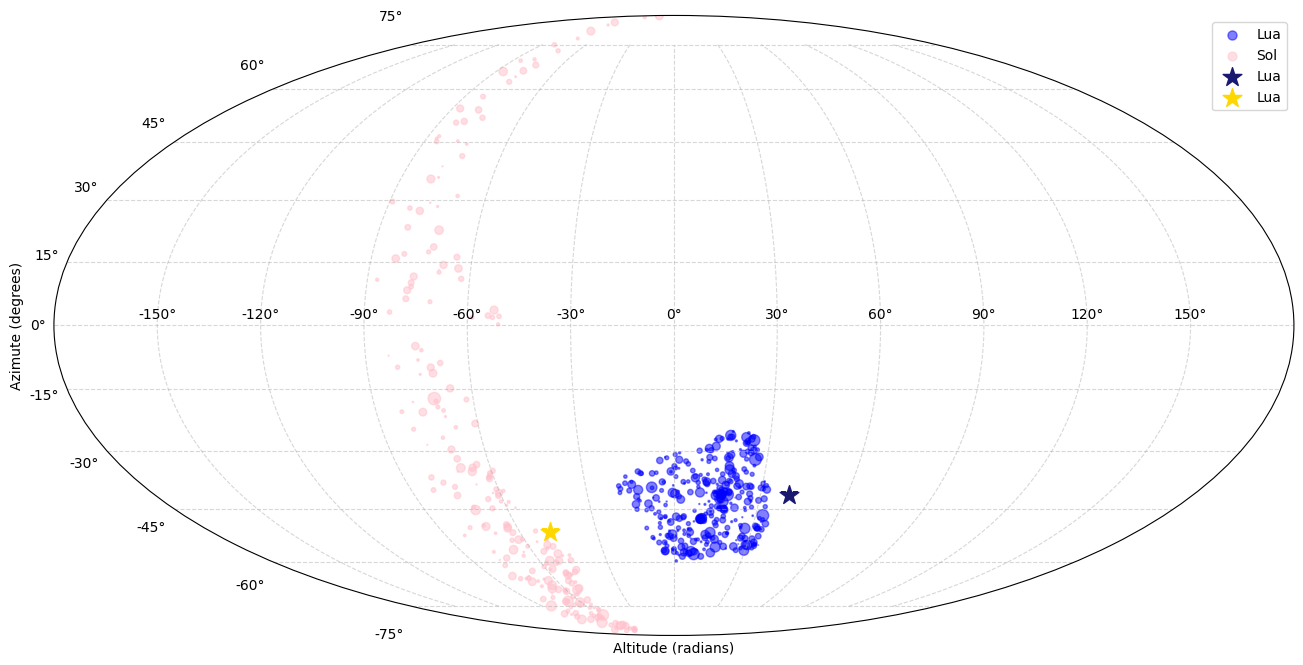

In [ ]:
import matplotlib.pyplot as plt

def get_size(magnitude):
    """Calculate the size of the star based on its magnitude."""
    return 100 * (6 - magnitude) / 6

def get_color(constellation):
    """Return a color based on the constellation."""
    zodiac_constellations = ['Ari', 'Tau', 'Gem', 'Cnc', 'Leo', 'Vir', 
                        'Lib', 'Sco', 'Sgr', 'Cap', 'Aqr', 'Psc']
    colors = {
        'Aries': 'blue',
        'Taurus': 'orange',
        'Gemini': 'red',
        'Cancer': 'green',
        'Leo': 'purple',
        'Virgo': 'cyan',
        'Libra': 'magenta',
        'Scorpio': 'yellow',
        'Sgr': 'brown',
        'Capricornus': 'pink',
        'Aquarius': 'gray',
        'Psc': 'lightblue',
    }
    return colors.get(constellation, 'gray')

fig, ax = plt.subplots(figsize=(16, 9), subplot_kw={'projection': 'mollweide'})
ax.scatter(np.radians(moon_box.alt), np.radians(moon_box.az), s=get_size(moon_box.magnitude.values), c=get_color(moon_box.const.values[0]), label='Lua', alpha=0.5)
ax.scatter(np.radians(sol_box.alt), np.radians(sol_box.az), s=get_size(sol_box.magnitude.values), c=get_color(sol_box.const.values[0]), label='Sol', alpha=0.5)
ax.set_xlabel('Altitude (radians)')
ax.set_ylabel('Azimute (degrees)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.scatter(np.radians(lua_alt.degrees), np.radians(lua_az.degrees), s=200, c='midnightblue', marker='*', label='Lua')
ax.scatter(np.radians(sol_alt.degrees), np.radians(sol_az.degrees), s=200, c='gold', marker='*', label='Lua')
ax.legend()
plt.show()